In [1]:
from scipy.sparse import csr_matrix
import networkx as nx
import pandas as pd
import numpy as np
import random
import time
import zarr

# Compressed Sparse Row (CSR) matrix

Three arrays:
1. Row Index Array: This stores the index of the column of the first non-zero element in the new row.
2. Column Index Array: This stores the column index of the non-zero element.
3. Value Array: This stores the value of the non-zero element.

The row index array is of size `n+1` where `n` is the number of rows in the matrix. The last element of the row index array is the number of non-zero elements in the matrix. ([Source](https://youtu.be/a2LXVFmGH_Q))

Example:
$$
A = 
\begin{bmatrix}
2 & 0 & 0 & 2 & 0 \\
3 & 4 & 2 & 5 & 0 \\
5 & 0 & 0 & 8 & 17 \\
0 & 0 & 10 & 16 & 0 \\
0 & 0 & 0 & 0 & 14 \\
\end{bmatrix}
$$

The CSR matrix representation of the above matrix is:

| nz_idx | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| row_idx | 0 | - | 2 | - | - | - | 6 | - | - | 9 | - | 11 | 12 |
| col_idx | 0 | 3 | 0 | 1 | 2 | 3 | 0 | 3 | 4 | 2 | 3 | 4 | - |
| val | 2 | 2 | 3 | 4 | 2 | 5 | 5 | 8 | 17 | 10 | 16 | 14 | - |


In [2]:
sparse_matrix = np.array(
    [
        [2, 0, 0,  2,  0],
        [3, 4, 2,  5,  0],
        [5, 0, 0,  8,  17],
        [0, 0, 10, 16, 0],
        [0, 0, 0,  0,  14]
    ]
)
sparse_matrix

array([[ 2,  0,  0,  2,  0],
       [ 3,  4,  2,  5,  0],
       [ 5,  0,  0,  8, 17],
       [ 0,  0, 10, 16,  0],
       [ 0,  0,  0,  0, 14]])

In [3]:
n_nz = 0
for i in range(sparse_matrix.shape[0]):
    for j in range(sparse_matrix.shape[1]):
        if sparse_matrix[i, j] != 0:
            n_nz += 1
n_nz

12

In [4]:
row_idx = []
col_idx = []
val = []
for i in range(sparse_matrix.shape[0]):
    start_j = -1
    for j in range(sparse_matrix.shape[1]):
        if sparse_matrix[i, j] != 0:
            if start_j == -1:
                start_j = j
                row_idx.append(len(col_idx))
            col_idx.append(j)
            val.append(sparse_matrix[i, j])
row_idx.append(len(col_idx))

In [5]:
row_idx

[0, 2, 6, 9, 11, 12]

In [6]:
print(f'Row indices: {row_idx}\nColumn indices: {col_idx}\nValues: {val}')

Row indices: [0, 2, 6, 9, 11, 12]
Column indices: [0, 3, 0, 1, 2, 3, 0, 3, 4, 2, 3, 4]
Values: [2, 2, 3, 4, 2, 5, 5, 8, 17, 10, 16, 14]


# Graph as CSR

In [7]:
# Graph
n = 100
G = nx.Graph()
G.add_nodes_from(range(n)) # nodes

In [8]:
# Add random edges with random weights
for i in range(n):
    for j in range(i + 1, n):
        if random.random() < 0.5:
            weight = random.random()  # Random weight between [0, 1]
            G.add_edge(i, j, weight=weight)

In [9]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 100
Number of edges: 2446


In [10]:
print("Edges with weights:")
for u, v, d in G.edges(data=True):
    print(f"Edge ({u}, {v}), weight: {d['weight']}")

Edges with weights:
Edge (0, 1), weight: 0.515802635067238
Edge (0, 3), weight: 0.7103292602499348
Edge (0, 4), weight: 0.10833885516270225
Edge (0, 7), weight: 0.35168143525707896
Edge (0, 9), weight: 0.8108810315430046
Edge (0, 10), weight: 0.714522306937728
Edge (0, 14), weight: 0.480553495046223
Edge (0, 17), weight: 0.6049562943255522
Edge (0, 23), weight: 0.39441549134201004
Edge (0, 24), weight: 0.11753949823289334
Edge (0, 27), weight: 0.6666308834004362
Edge (0, 32), weight: 0.8212779937579121
Edge (0, 33), weight: 0.7249579016742796
Edge (0, 35), weight: 0.10532298959262676
Edge (0, 40), weight: 0.30847277406134244
Edge (0, 44), weight: 0.9884826168281864
Edge (0, 45), weight: 0.769847253539086
Edge (0, 48), weight: 0.7955379395980676
Edge (0, 50), weight: 0.11541536008244968
Edge (0, 51), weight: 0.49486277347633345
Edge (0, 53), weight: 0.20085769417136845
Edge (0, 54), weight: 0.7569696350685909
Edge (0, 57), weight: 0.35581229360000854
Edge (0, 58), weight: 0.164412607645

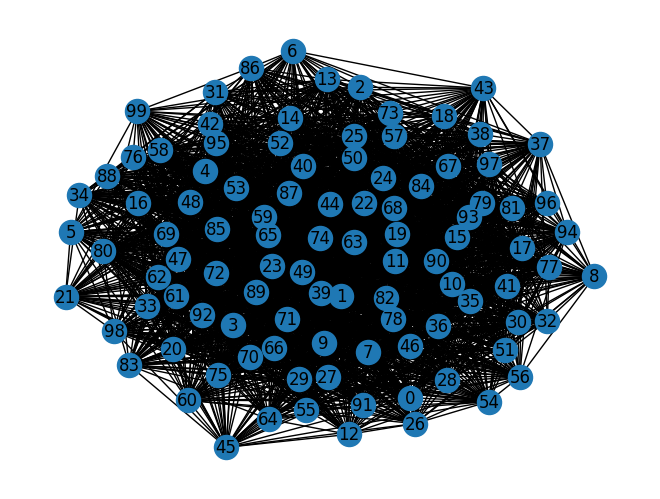

In [11]:
nx.draw(G, with_labels=True)

In [12]:
adj_matrix = nx.adjacency_matrix(G)
print(adj_matrix.toarray())

[[0.         0.51580264 0.         ... 0.07084199 0.23213604 0.        ]
 [0.51580264 0.         0.6325661  ... 0.         0.         0.82615784]
 [0.         0.6325661  0.         ... 0.         0.         0.99827503]
 ...
 [0.07084199 0.         0.         ... 0.         0.2852211  0.82282106]
 [0.23213604 0.         0.         ... 0.2852211  0.         0.        ]
 [0.         0.82615784 0.99827503 ... 0.82282106 0.         0.        ]]


In [13]:
# CSR Matrix from adj_matrix
n_nz = 0
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] != 0:
            n_nz += 1
n_nz

4892

In [14]:
row_idx = []
col_idx = []
val = []

for i in range(adj_matrix.shape[0]):
    start_j = -1
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] != 0:
            if start_j == -1:
                start_j = j
                row_idx.append(len(col_idx))
            col_idx.append(j)
            val.append(adj_matrix[i, j])

In [15]:
print(f'Row indices: {row_idx}\nColumn indices: {col_idx}\nValues: {val}')

Row indices: [0, 45, 96, 142, 186, 235, 279, 318, 373, 412, 461, 510, 562, 603, 654, 705, 754, 796, 851, 893, 947, 992, 1032, 1087, 1143, 1196, 1246, 1291, 1348, 1394, 1446, 1491, 1532, 1577, 1632, 1682, 1729, 1775, 1828, 1876, 1935, 1985, 2034, 2080, 2126, 2178, 2219, 2273, 2323, 2376, 2432, 2483, 2529, 2577, 2630, 2675, 2720, 2765, 2817, 2869, 2920, 2967, 3011, 3063, 3121, 3163, 3214, 3260, 3307, 3364, 3419, 3468, 3519, 3573, 3617, 3677, 3727, 3771, 3820, 3872, 3917, 3971, 4025, 4078, 4127, 4171, 4218, 4260, 4319, 4365, 4420, 4472, 4514, 4570, 4628, 4676, 4723, 4769, 4815, 4854]
Column indices: [1, 3, 4, 7, 9, 10, 14, 17, 23, 24, 27, 32, 33, 35, 40, 44, 45, 48, 50, 51, 53, 54, 57, 58, 59, 60, 62, 63, 64, 65, 66, 70, 71, 77, 78, 81, 83, 85, 89, 92, 94, 95, 96, 97, 98, 0, 2, 4, 7, 9, 10, 11, 13, 15, 18, 20, 21, 24, 25, 26, 27, 30, 33, 34, 35, 37, 38, 40, 42, 44, 45, 46, 48, 49, 53, 54, 56, 60, 62, 63, 64, 67, 69, 72, 75, 76, 77, 78, 83, 84, 87, 88, 89, 90, 95, 99, 1, 3, 5, 6, 8, 10, 13

In [16]:
print(f'Row indices: {len(row_idx)}\nColumn indices: {len(col_idx)}\nValues: {len(val)}')

Row indices: 100
Column indices: 4892
Values: 4892


In [17]:
from scipy.sparse import csr_matrix

# CSR Matrix from adj_matrix using scipy
adj_matrix_csr = csr_matrix(adj_matrix)

# Partition

In [18]:
def partition_number(n, k, start=1):
    if k == 1:
        return [[n]] if n >= start else []
    
    partitions = []
    for i in range(start, n - k + 2):
        for p in partition_number(n - i, k - 1, i + 1):
            partitions.append([i] + p)
    
    return partitions

In [19]:
def grouping(nodes_array, partition_array):
    n_partitions = len(partition_array)
    # Randomly assign nodes to partitions -- [13, 16, 21, 23, 27]
    nodes = list(np.random.permutation(nodes_array))
    partitioned_nodes = []
    # partition_array contains the number of nodes in each partition
    for i in range(n_partitions):
        in_part = []
        for j in range(partition_array[i]):
            in_part.append(nodes.pop())
        partitioned_nodes.append(in_part)
    return partitioned_nodes

In [20]:
# A partition P of V into g groups: P = {P₁, P₂, ..., Pg}, where g ≥ 2 and |Pᵢ| ≠ |Pⱼ| for some i ≠ j.
V = list(G.nodes())
g = 5
random.shuffle(V)
parts = partition_number(len(V), g, start=2)
random.shuffle(parts)

In [21]:
part = random.choice(parts)
part

[4, 11, 27, 28, 30]

In [22]:
partition_nodes = grouping(V, part)
for part in partition_nodes:
    print(len(part))

4
11
27
28
30


# Feature Matrix

In [23]:
# A feature matrix M ∈ ℝⁿˣᶠ stored. Each row of M corresponds to a node in V and each column corresponds to a feature.
num_features = 10
for node in G.nodes():
    G.nodes[node]['features'] = np.random.rand(num_features)

# To DO Mapping from node to feature matrix
zarr_M = zarr.zeros((len(G.nodes), num_features+1), dtype=np.float32)
for node in G.nodes():
    # add partition info
    grp = np.where([node in part for part in partition_nodes])[0][0]
    G.nodes[node]['group'] = grp
    vals = np.append(G.nodes[node]['features'], G.nodes[node]['group'])
    zarr_M[node] = vals

In [24]:
# convert to zarr array
zarr_M = zarr.array(zarr_M, chunks=(10, num_features+1), dtype=np.float32, store='feature_matrix.zarr', overwrite=True)

In [212]:
# Add group info to nodes
for i, part in enumerate(partition_nodes):
    for node in part:
        G.nodes[node]['group'] = i

In [213]:
zarr_M.info

Type,zarr.core.Array
Data type,float32
Shape,"(100, 11)"
Chunk shape,"(10, 11)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4400 (4.3K)
No. bytes stored,4898 (4.8K)
Storage ratio,0.9
